# CS559 Project Team4
*  Ahmed-Ghani Nan-Chen Yonghao-Zhang

###  Analysing train dataset:

In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

train_data = pd.read_csv('train.csv')

Initial screening to identify features to potentially drop. This includes checking for missing values and examining feature correlations.

In [89]:
train_data.head(), train_data.columns.tolist()

(   Unnamed: 0    Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley  \
 0          64    65          60       RL          NaN     9375   Pave   NaN   
 1         651   652          70       RL         60.0     9084   Pave   NaN   
 2         260   261          80       RL        120.0    19296   Pave   NaN   
 3        1089  1090         120       FV         37.0     3316   Pave  Pave   
 4        1112  1113          20       RL         73.0     7100   Pave   NaN   
 
   LotShape LandContour  ... PoolArea PoolQC  Fence MiscFeature MiscVal MoSold  \
 0      Reg         Lvl  ...        0    NaN  GdPrv         NaN       0      2   
 1      Reg         Lvl  ...        0    NaN  MnPrv         NaN       0     10   
 2      Reg         Lvl  ...        0    NaN   GdWo         NaN       0      5   
 3      IR1         Lvl  ...        0    NaN    NaN         NaN       0      4   
 4      IR1         Lvl  ...        0    NaN    NaN         NaN       0      7   
 
   YrSold SaleType  Sale

In [90]:
# Checking for missing values and their percentage
missing_values = train_data.isnull().mean() * 100

# Identifying columns with a high percentage of missing values (threshold set to 50%)
columns_with_many_missing = missing_values[missing_values > 50].index.tolist()

columns_with_many_missing

['Alley', 'MasVnrType', 'PoolQC', 'Fence', 'MiscFeature']

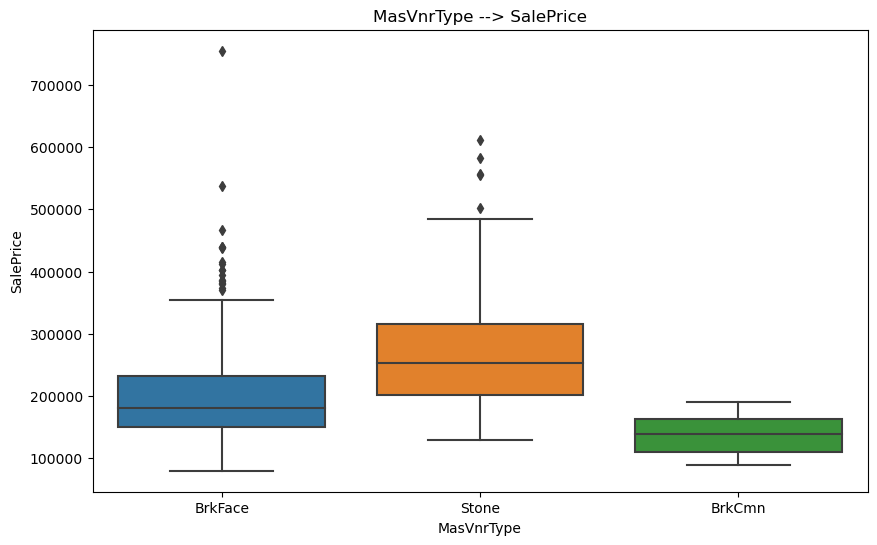

In [91]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='MasVnrType', y='SalePrice', data=train_data)

plt.title('MasVnrType --> SalePrice')
plt.xlabel('MasVnrType')
plt.ylabel('SalePrice')
plt.show()

In [92]:
model = ols('SalePrice ~ C(MasVnrType)', data=train_data).fit()
anova_results = sm.stats.anova_lm(model, typ=2)

print(anova_results)

                     sum_sq     df          F        PR(>F)
C(MasVnrType)  3.697598e+11    2.0  24.719178  7.429486e-11
Residual       3.029079e+12  405.0        NaN           NaN


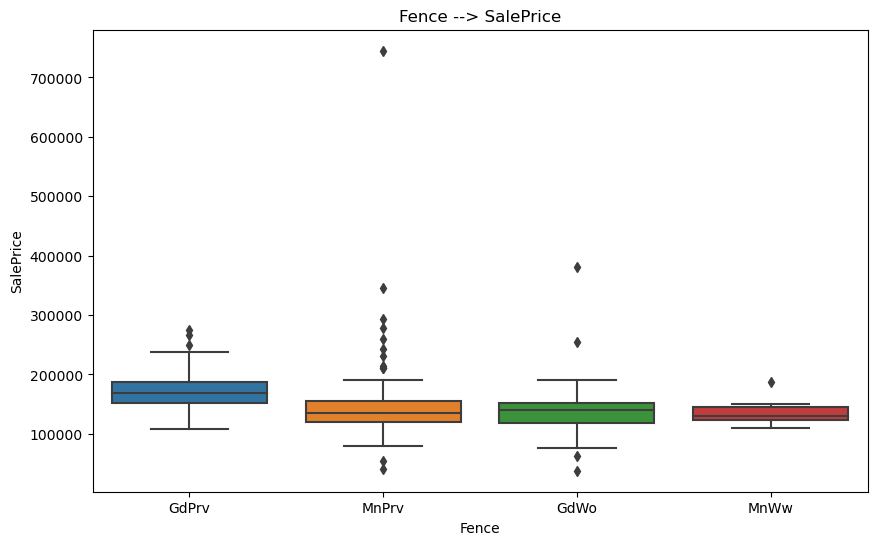

In [93]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Fence', y='SalePrice', data=train_data)

plt.title('Fence --> SalePrice')
plt.xlabel('Fence')
plt.ylabel('SalePrice')
plt.show()

Based on the analysis and ANOVA test results:
* Remove the features 'Alley', 'PoolQC', 'MiscFeature', and 'Fence' due to their extensive data missingness and the non-significant impact on house prices as indicated by both the visualization (box plots) and statistical tests.
* Keep the 'MasVnrType' feature as it may contain valuable information for predicting the model's outcome.

In [94]:
# Drop the specified columns
train_data.drop(['Alley', 'PoolQC', 'MiscFeature', 'Fence'], axis=1, inplace=True)

In [95]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     1022 non-null   int64  
 1   Id             1022 non-null   int64  
 2   MSSubClass     1022 non-null   int64  
 3   MSZoning       1022 non-null   object 
 4   LotFrontage    842 non-null    float64
 5   LotArea        1022 non-null   int64  
 6   Street         1022 non-null   object 
 7   LotShape       1022 non-null   object 
 8   LandContour    1022 non-null   object 
 9   Utilities      1022 non-null   object 
 10  LotConfig      1022 non-null   object 
 11  LandSlope      1022 non-null   object 
 12  Neighborhood   1022 non-null   object 
 13  Condition1     1022 non-null   object 
 14  Condition2     1022 non-null   object 
 15  BldgType       1022 non-null   object 
 16  HouseStyle     1022 non-null   object 
 17  OverallQual    1022 non-null   int64  
 18  OverallC

Handling missing values for numerical features:

In [96]:
# Impute missing values with the median for numerical features
numerical_features = train_data.select_dtypes(include=[np.number])
numerical_features.isnull().sum()

Unnamed: 0         0
Id                 0
MSSubClass         0
LotFrontage      180
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         7
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       54
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
SalePrice          0
dtype: int64

Deal with 'LotFrontage': Using the k-Nearest Neighbors (k-NN) algorithm to estimate missing values for LotFrontage.

In [97]:
# Select relevant features
features = ['LotFrontage', 'LotArea', 'Neighborhood']
data = train_data[features]
data = pd.get_dummies(data)

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# KNN Imputer
imputer = KNNImputer(n_neighbors=5)
data_imputed = imputer.fit_transform(data_scaled)

# Convert the scaled data back to the original scale
data_imputed_original_scale = scaler.inverse_transform(data_imputed)

# Update LotFrontage in train_data
train_data['LotFrontage'] = data_imputed_original_scale[:, 4]

Deal with 'GarageYrBlt': Assigning a value of 0 to 'GarageYrBlt' for properties without a garage.

In [98]:
# Fill missing values for 'GarageYrBlt' with 0
train_data['GarageYrBlt'].fillna(0, inplace=True)

Deal with 'MasVnrArea': Assigning a value of 0 to 'MasVnrArea' for there being no masonry veneer.

In [99]:
# Fill missing values for 'MasVnrArea' with 0
train_data['MasVnrArea'].fillna(0, inplace=True)

In [100]:
numerical_features = numerical_features.fillna(numerical_features.median())
# Rechecking the correlation with the target variable 'SalePrice'
correlation_with_target_revised = numerical_features.corr()['SalePrice'].sort_values()

correlation_with_target_revised

KitchenAbvGr    -0.132590
EnclosedPorch   -0.128401
OverallCond     -0.083465
LowQualFinSF    -0.079848
MSSubClass      -0.076696
Unnamed: 0      -0.035452
Id              -0.035452
MiscVal         -0.029293
YrSold          -0.024045
BsmtHalfBath    -0.015511
BsmtFinSF2      -0.004278
3SsnPorch        0.032842
MoSold           0.060779
ScreenPorch      0.103018
PoolArea         0.116425
BedroomAbvGr     0.175139
BsmtUnfSF        0.218188
BsmtFullBath     0.226761
LotArea          0.257302
HalfBath         0.284235
WoodDeckSF       0.308526
2ndFlrSF         0.308750
OpenPorchSF      0.317960
LotFrontage      0.332637
BsmtFinSF1       0.398335
GarageYrBlt      0.464973
MasVnrArea       0.469071
Fireplaces       0.475610
YearRemodAdd     0.510283
YearBuilt        0.542773
TotRmsAbvGrd     0.555989
FullBath         0.570163
1stFlrSF         0.611725
TotalBsmtSF      0.612676
GarageArea       0.626319
GarageCars       0.634395
GrLivArea        0.719985
OverallQual      0.789634
SalePrice   

The correlation values offer insight into how various features relate to the target variable 'SalePrice'. The key insights from these correlations are:

* Highly Positive Correlations:
'OverallQual' shows the strongest positive correlation with SalePrice.
Other features with strong positive correlations include 'GrLivArea' , 'GarageCars' , 'GarageArea' , 'TotalBsmtSF' , and '1stFlrSF'.

* Moderately Positive Correlations:
Features such as 'FullBath' , 'TotRmsAbvGrd' , 'YearBuilt' , and 'YearRemodAdd' exhibit moderate positive correlations.

* Low or Negative Correlations:
Features like 'MSSubClass' , 'OverallCond' , 'EnclosedPorch' , and 'KitchenAbvGr' show low or even negative correlations.


Drop Low Correlation Features: Remove the features identified as having low or negative correlations with 'SalePrice'.

In [101]:
# Dropping features with low or negative correlations
features_to_drop = [
    'KitchenAbvGr', 'EnclosedPorch', 
    'OverallCond', 'LowQualFinSF', 
    'MSSubClass', 'Unnamed: 0', 
    'Id', 'MiscVal',
    'YrSold','LotFrontage',
    'BsmtHalfBath', 'BsmtFinSF2'
]

# Dropping the features from the DataFrame
train_data.drop(features_to_drop, axis=1, inplace=True)

In [102]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 66 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSZoning       1022 non-null   object 
 1   LotArea        1022 non-null   int64  
 2   Street         1022 non-null   object 
 3   LotShape       1022 non-null   object 
 4   LandContour    1022 non-null   object 
 5   Utilities      1022 non-null   object 
 6   LotConfig      1022 non-null   object 
 7   LandSlope      1022 non-null   object 
 8   Neighborhood   1022 non-null   object 
 9   Condition1     1022 non-null   object 
 10  Condition2     1022 non-null   object 
 11  BldgType       1022 non-null   object 
 12  HouseStyle     1022 non-null   object 
 13  OverallQual    1022 non-null   int64  
 14  YearBuilt      1022 non-null   int64  
 15  YearRemodAdd   1022 non-null   int64  
 16  RoofStyle      1022 non-null   object 
 17  RoofMatl       1022 non-null   object 
 18  Exterior

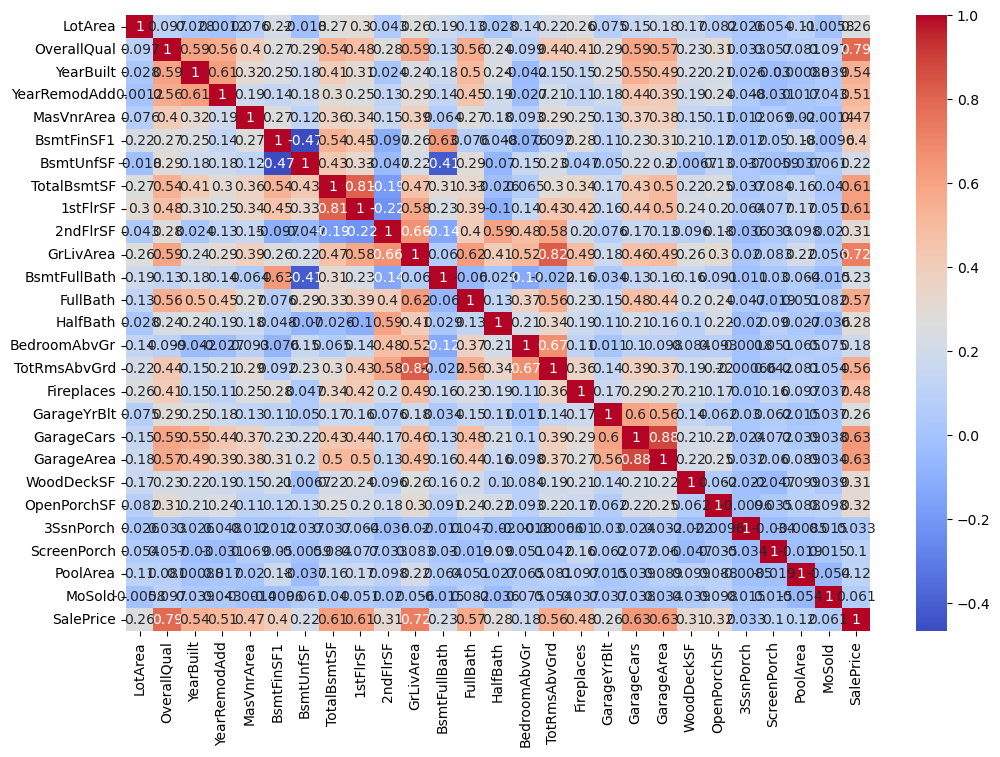

In [103]:
numerical_features = train_data.select_dtypes(include=[np.number])
correlation_matrix = numerical_features.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

As the heatmap shows: 
* 'GarageCars' and 'GarageArea' are highly correlated, which is intuitive since they both relate to the size of the garage.
* 'TotalBsmtSF' and '1stFlrSF' also show high correlation, likely because the first floor area is often similar to the area of the basement just below it.
* 'TotRmsAbvGrd' and 'GrLivArea' are highly correlated, which makes sense because more rooms typically mean more living area.

Drop 'GarageArea' ,'TotalBsmtSF','TotRmsAbvGrd'

In [104]:
features_to_drop = [
     'GarageArea' ,'TotalBsmtSF','TotRmsAbvGrd'
]
train_data.drop(features_to_drop, axis=1, inplace=True)

In [105]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 63 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSZoning       1022 non-null   object 
 1   LotArea        1022 non-null   int64  
 2   Street         1022 non-null   object 
 3   LotShape       1022 non-null   object 
 4   LandContour    1022 non-null   object 
 5   Utilities      1022 non-null   object 
 6   LotConfig      1022 non-null   object 
 7   LandSlope      1022 non-null   object 
 8   Neighborhood   1022 non-null   object 
 9   Condition1     1022 non-null   object 
 10  Condition2     1022 non-null   object 
 11  BldgType       1022 non-null   object 
 12  HouseStyle     1022 non-null   object 
 13  OverallQual    1022 non-null   int64  
 14  YearBuilt      1022 non-null   int64  
 15  YearRemodAdd   1022 non-null   int64  
 16  RoofStyle      1022 non-null   object 
 17  RoofMatl       1022 non-null   object 
 18  Exterior

Handling missing values in categorical data:

In [106]:
# List of categorical columns with missing values
categorical_cols_with_missing = ['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']

# Fill missing values with the mode (most common value) in each categorical column
for col in categorical_cols_with_missing:
    mode_value = train_data[col].mode()[0]  # Get the mode value for the column
    train_data[col].fillna(mode_value, inplace=True)  # Fill missing values with the mode
print(train_data[categorical_cols_with_missing].isnull().sum())

MasVnrType      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
FireplaceQu     0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
dtype: int64


In [107]:
train_data.isnull().sum().sum()


0

Identify categorical features and visualize relationship with 'SalePrice'

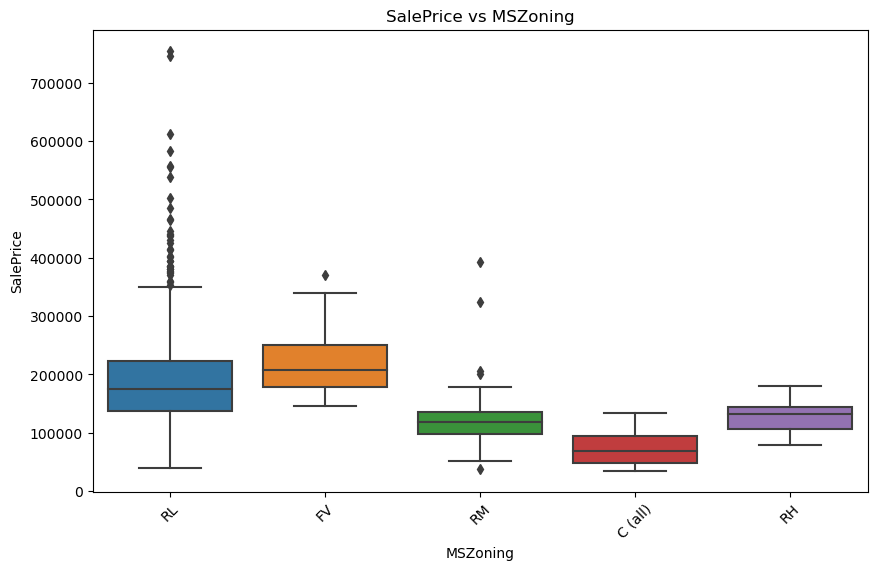

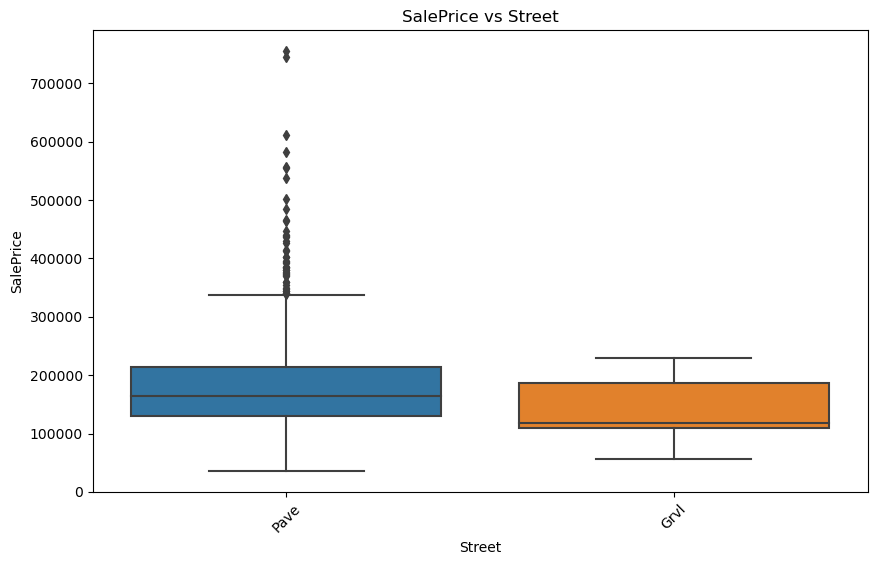

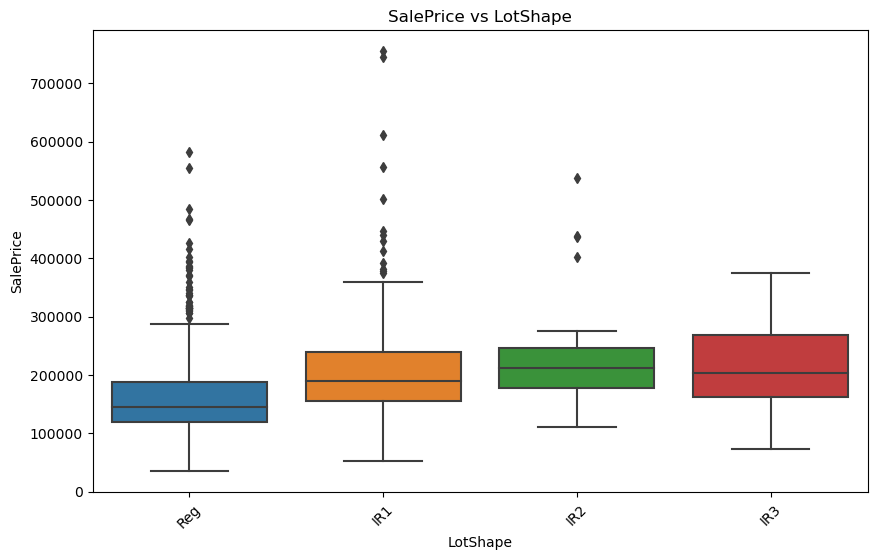

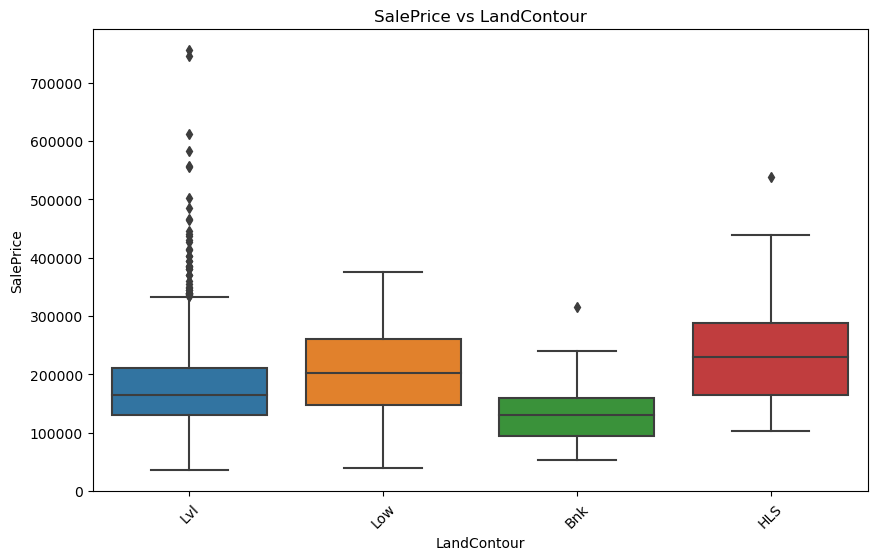

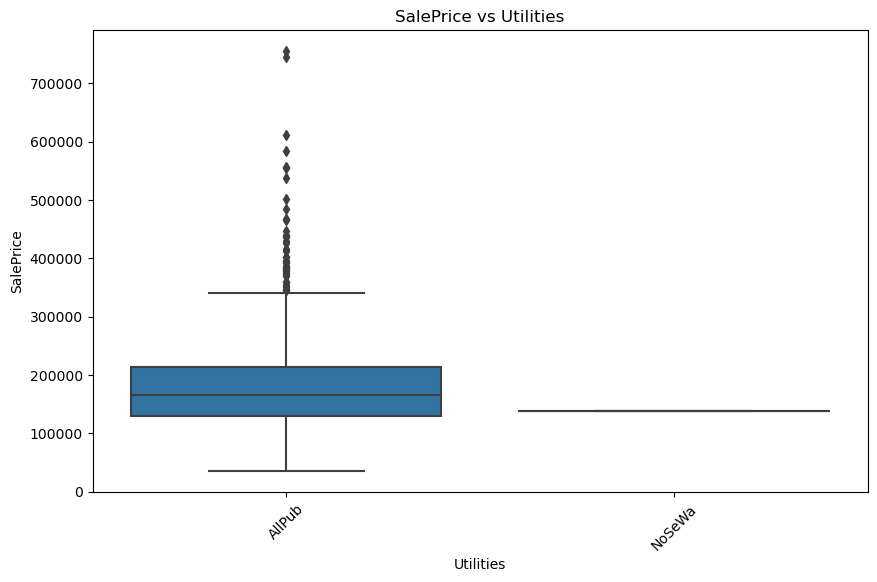

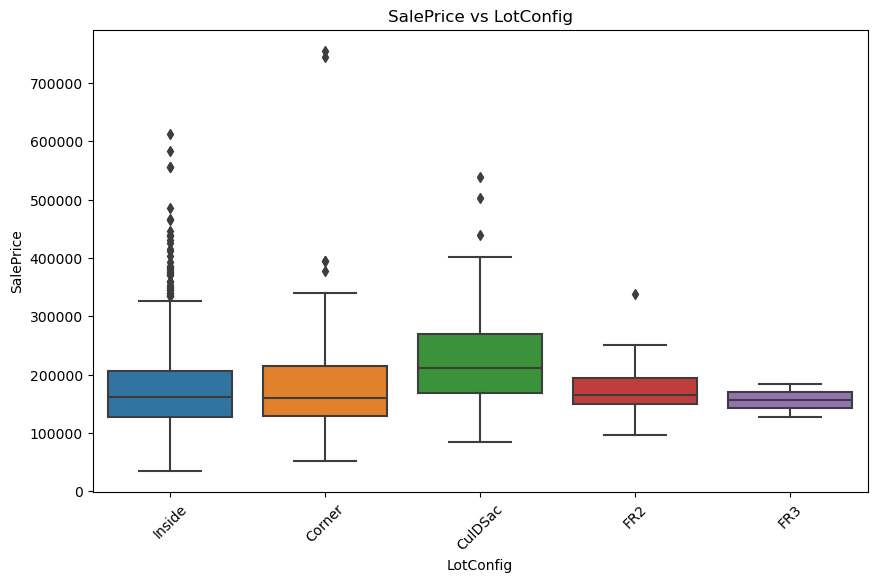

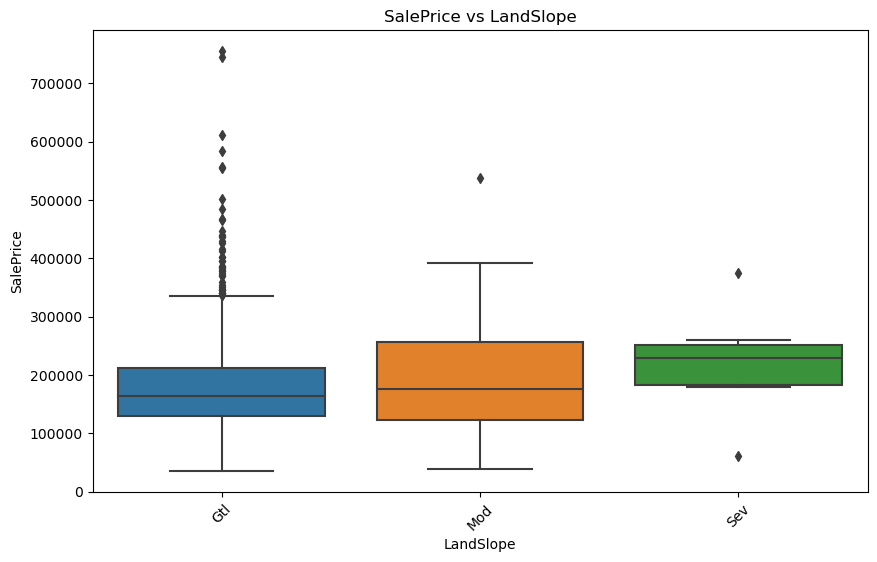

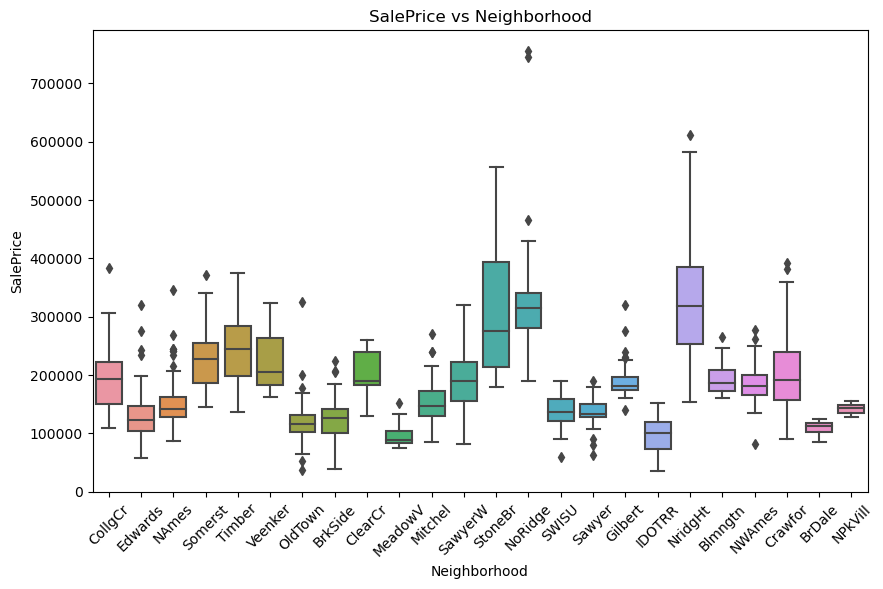

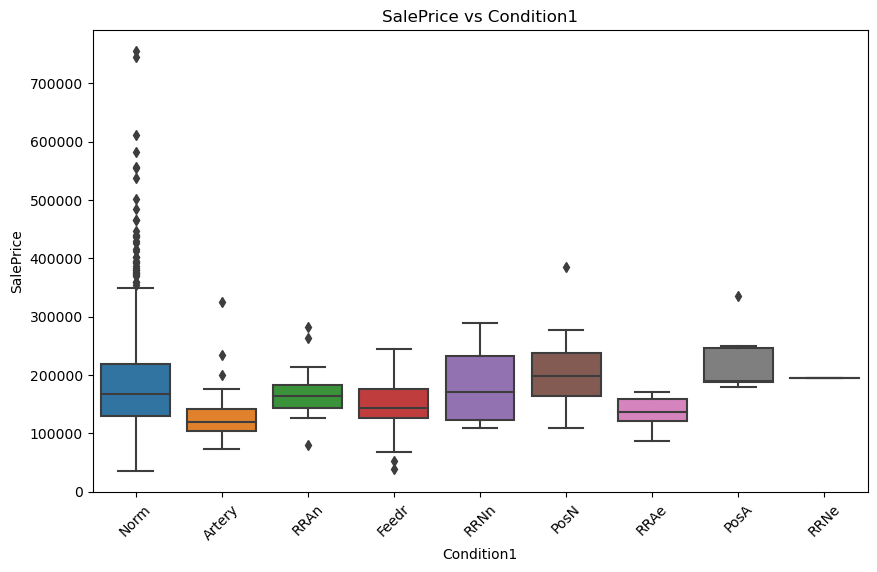

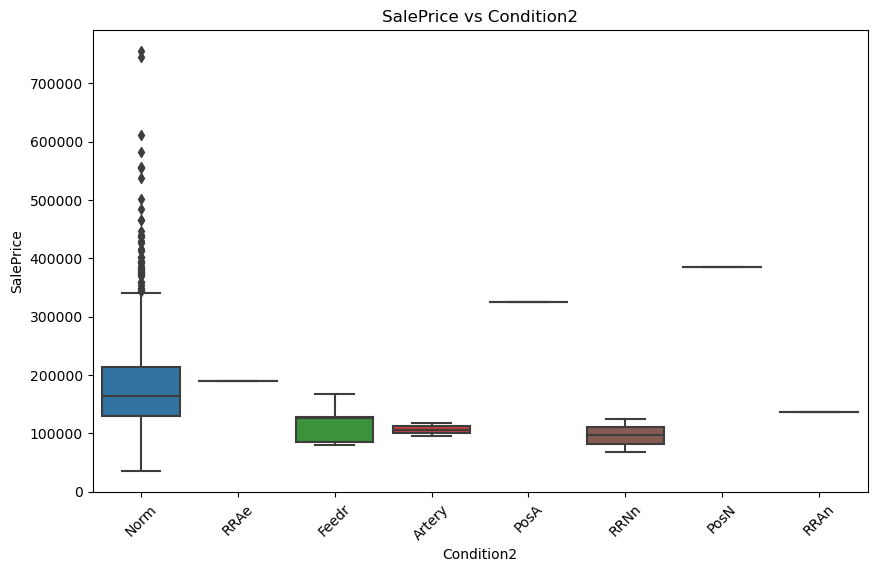

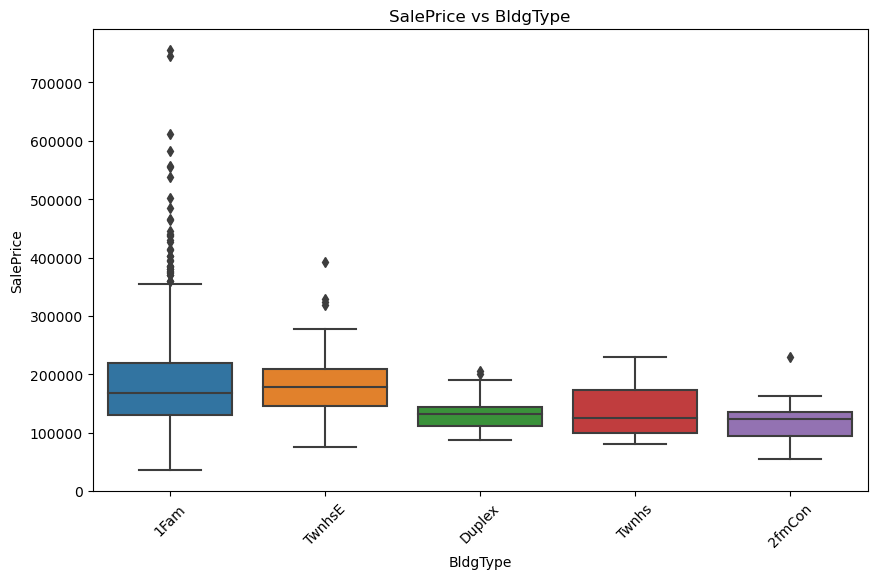

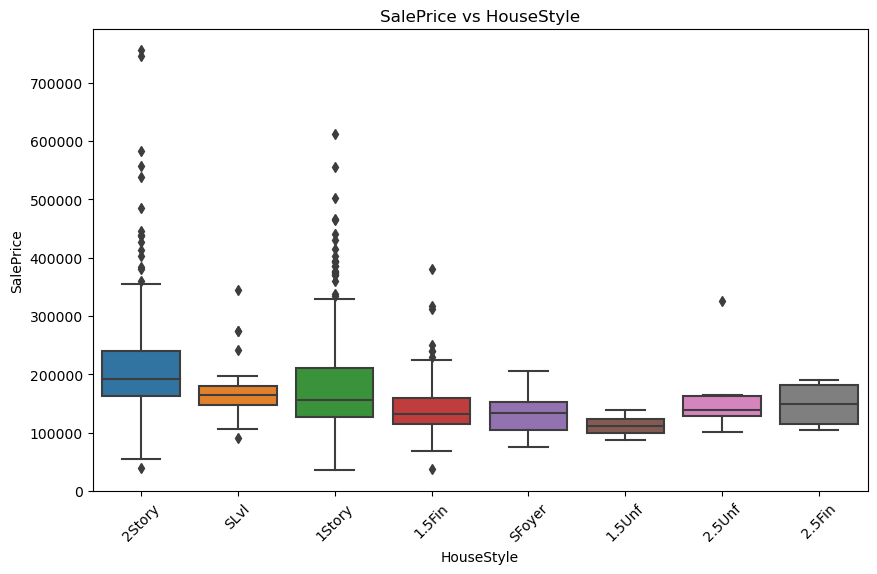

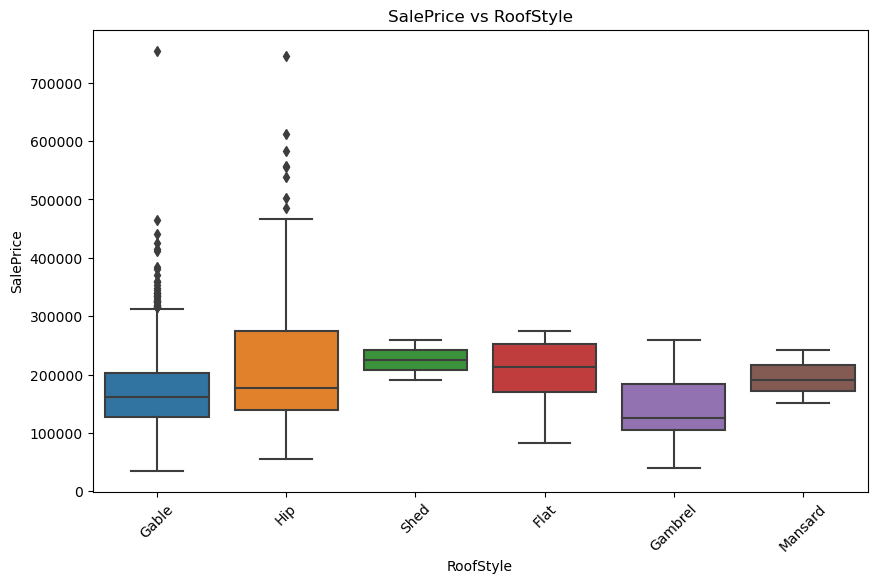

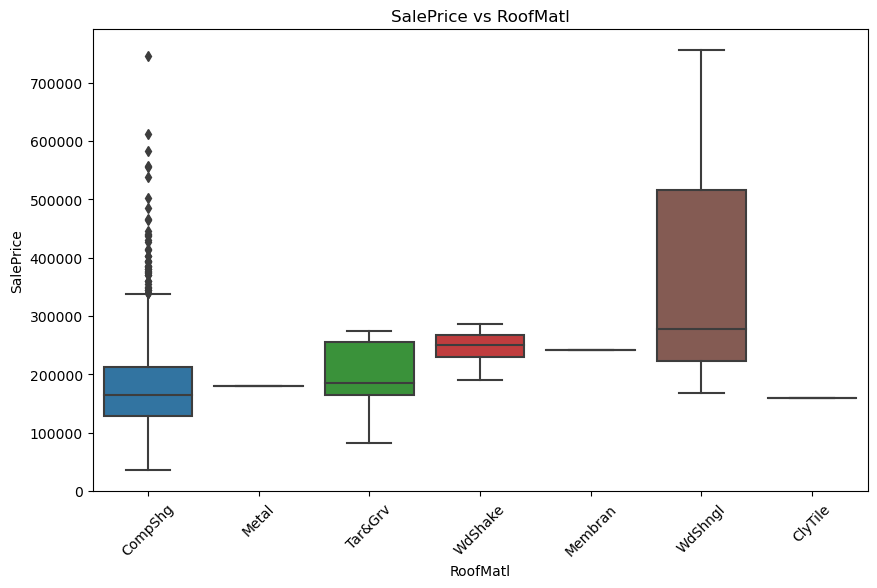

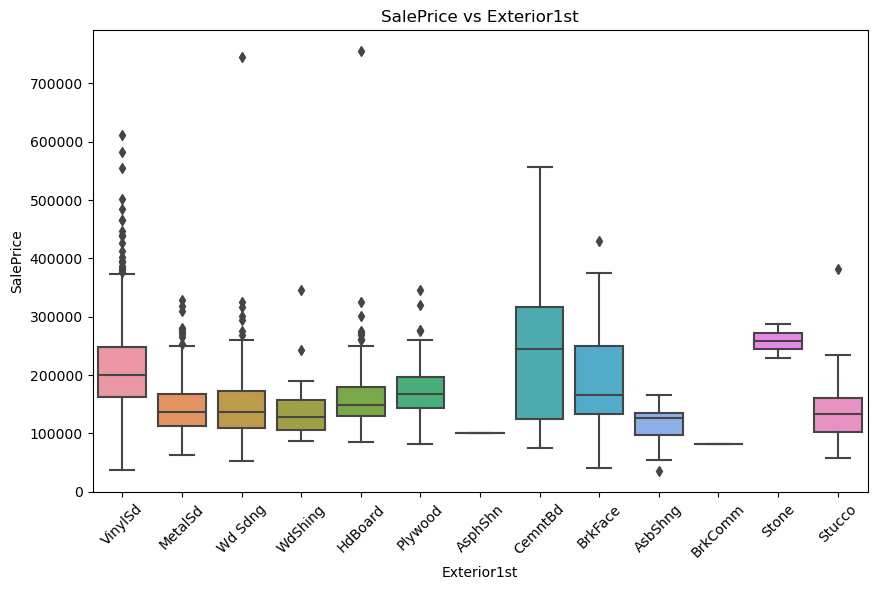

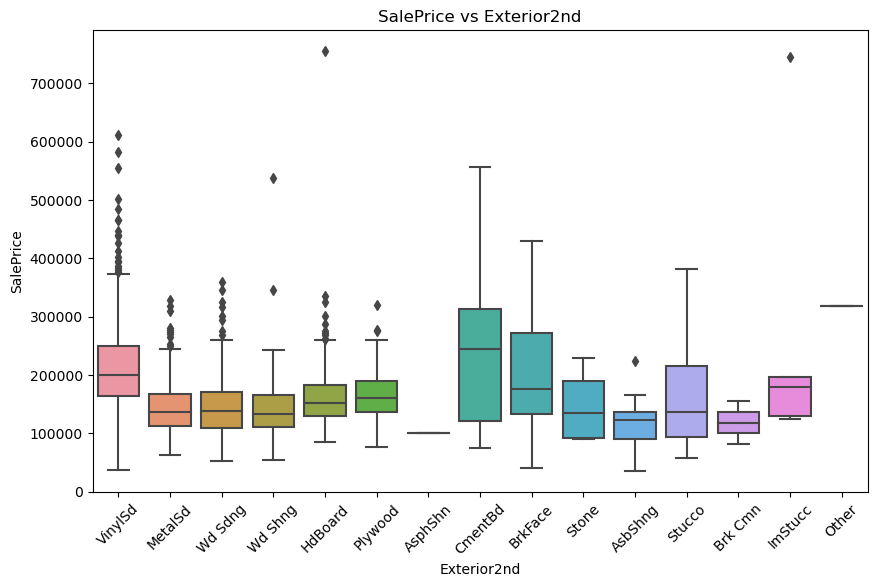

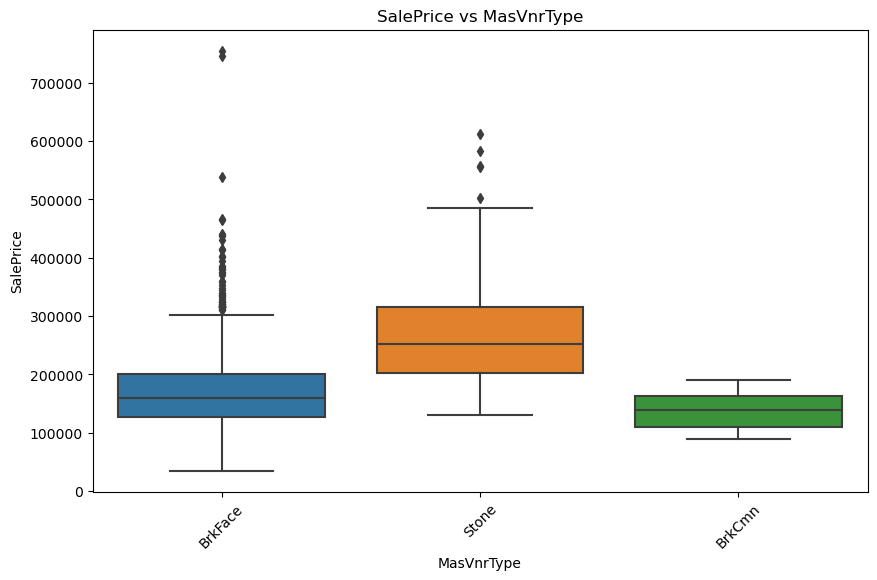

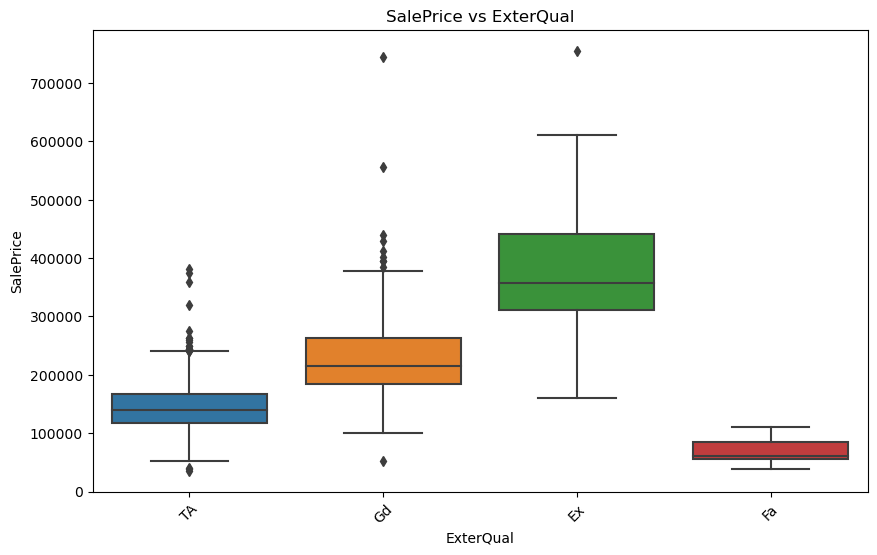

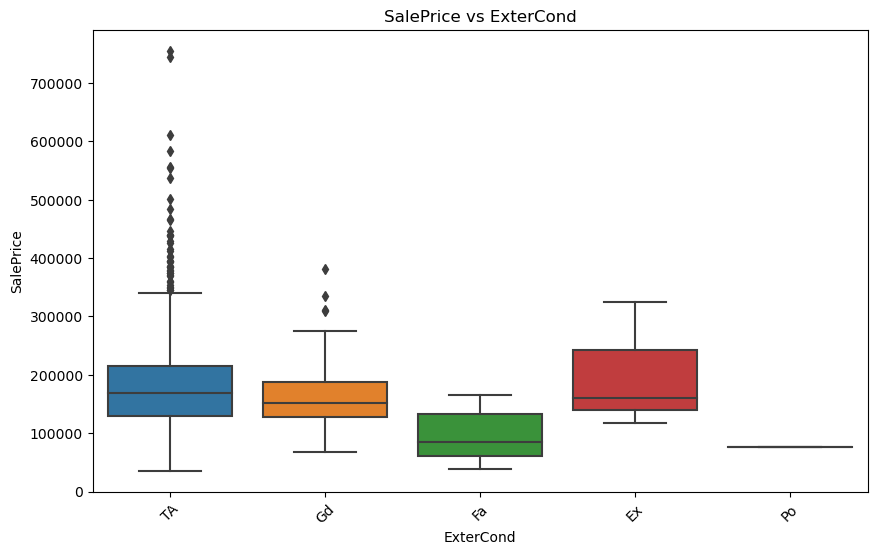

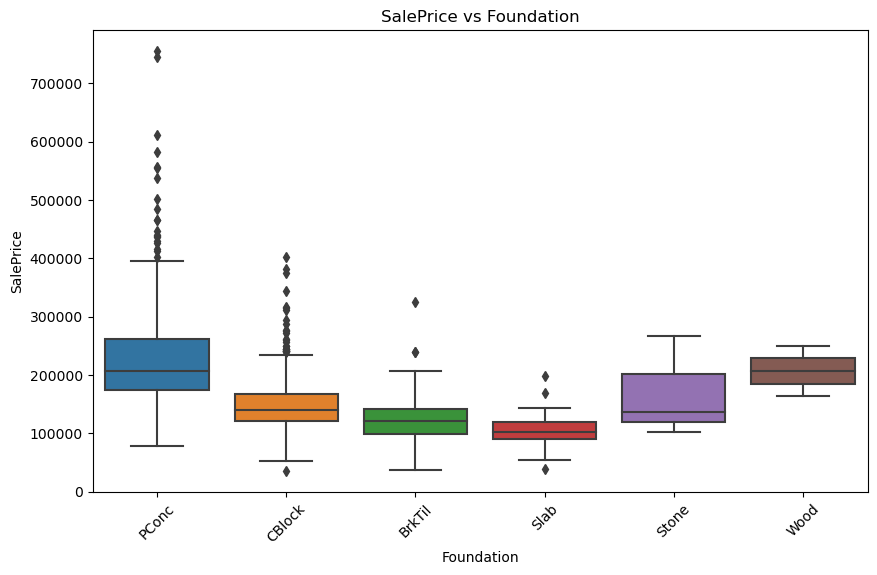

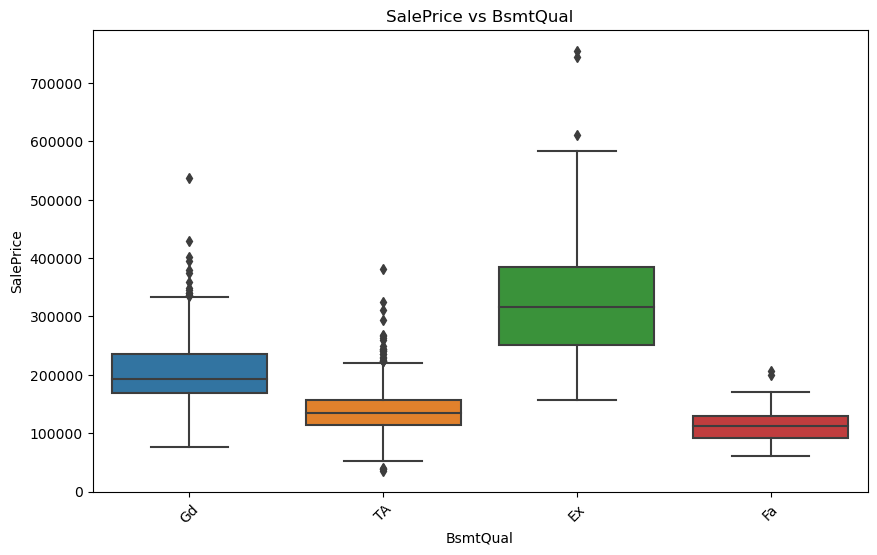

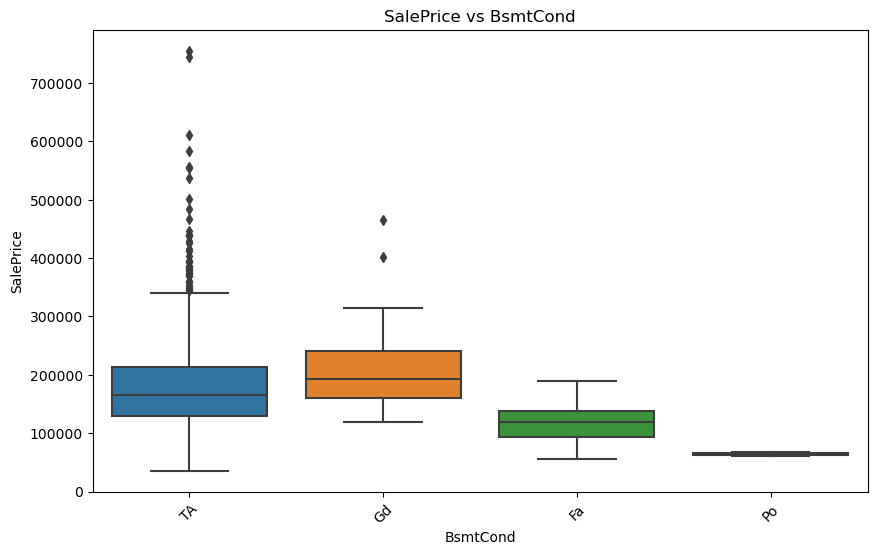

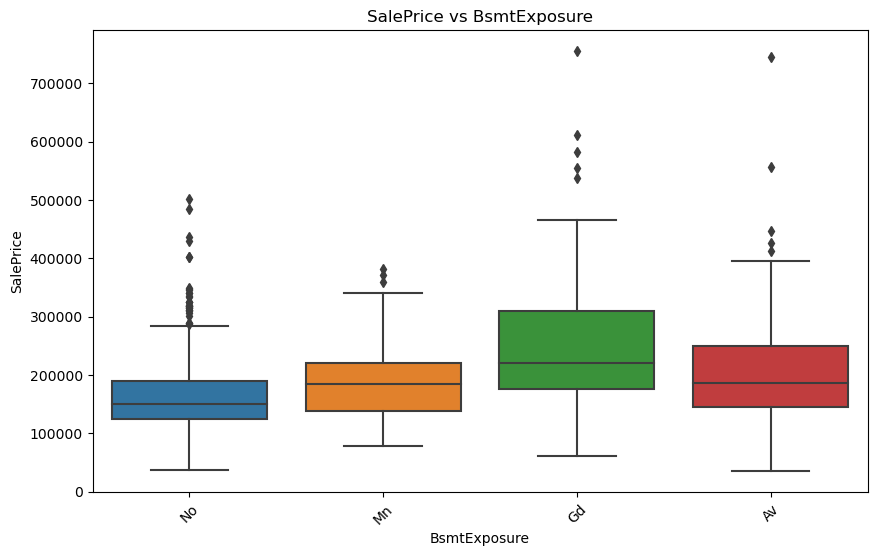

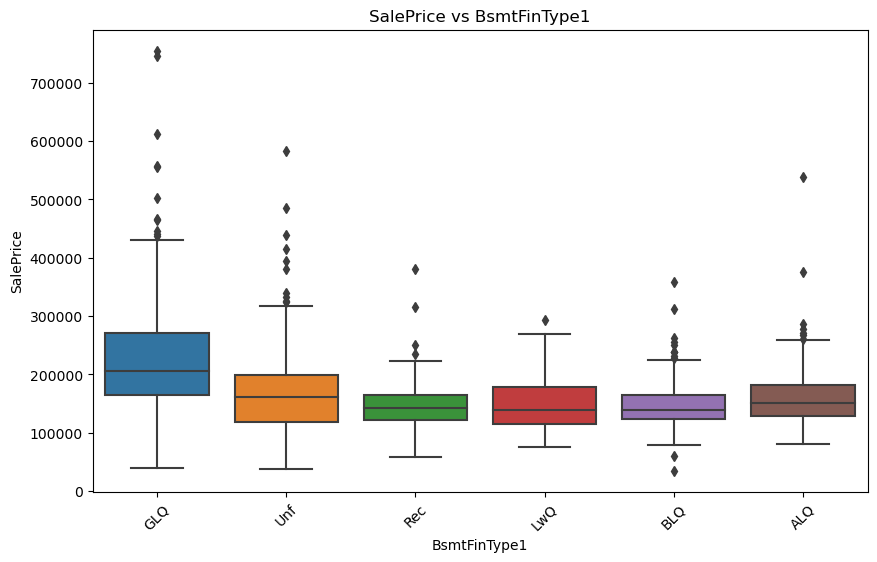

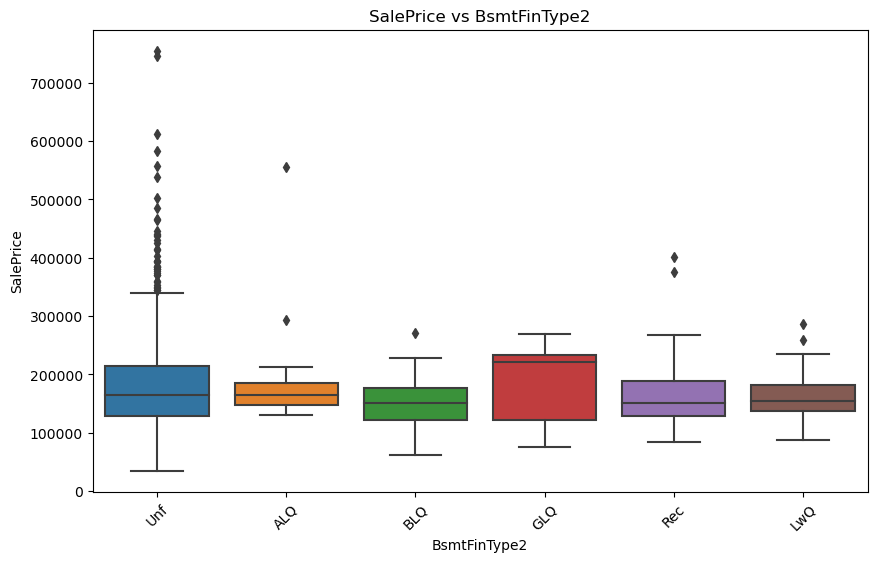

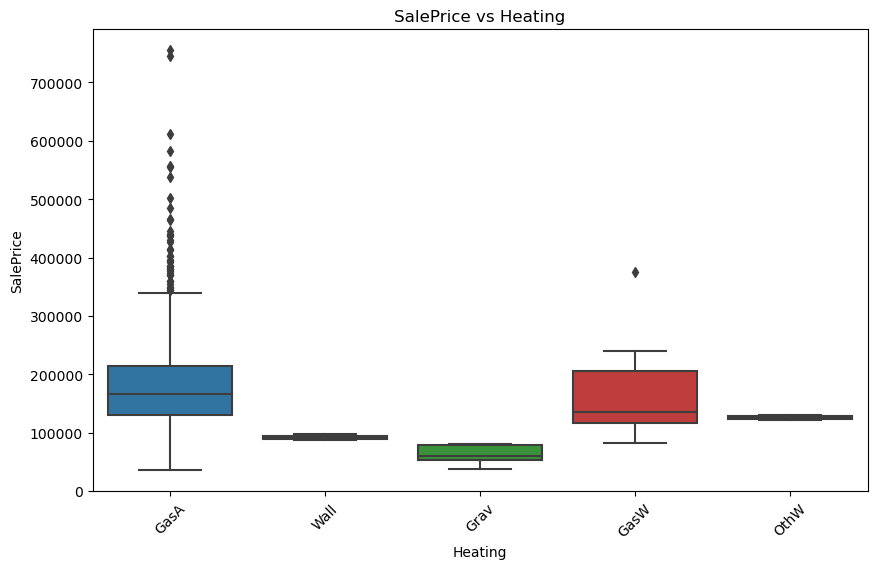

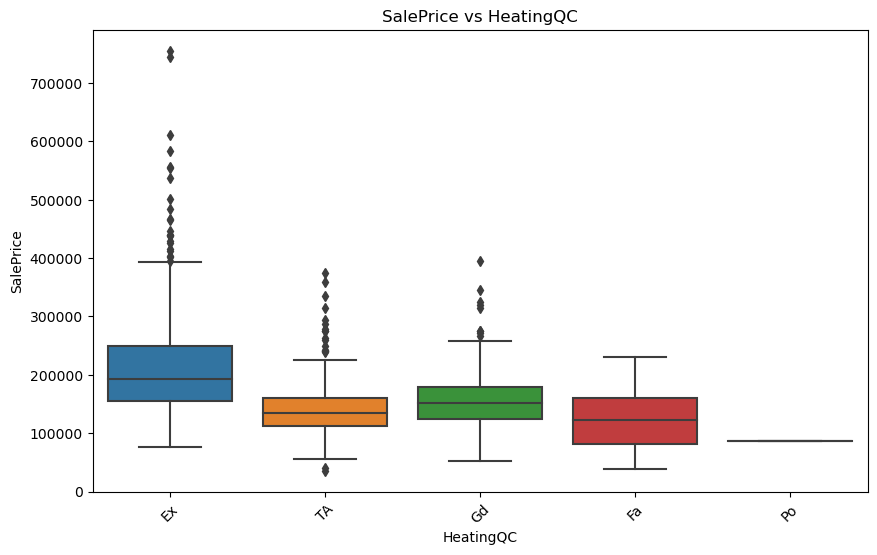

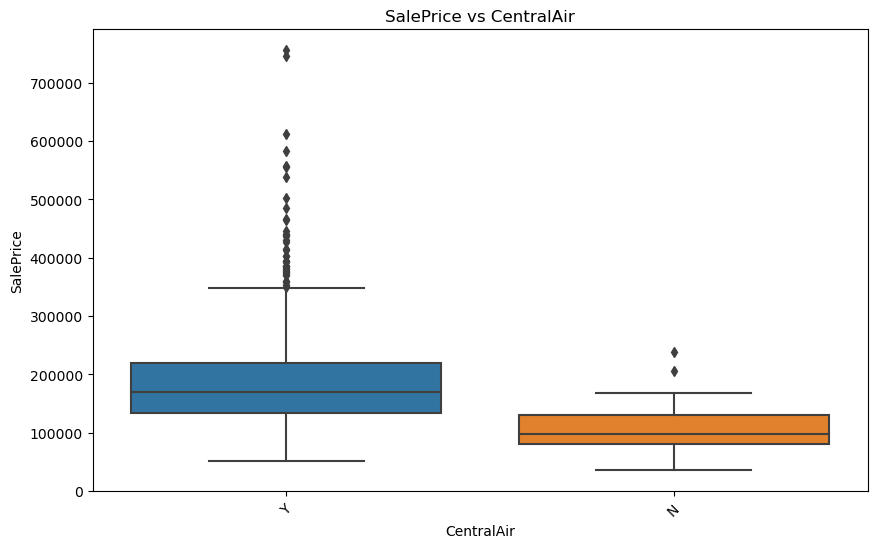

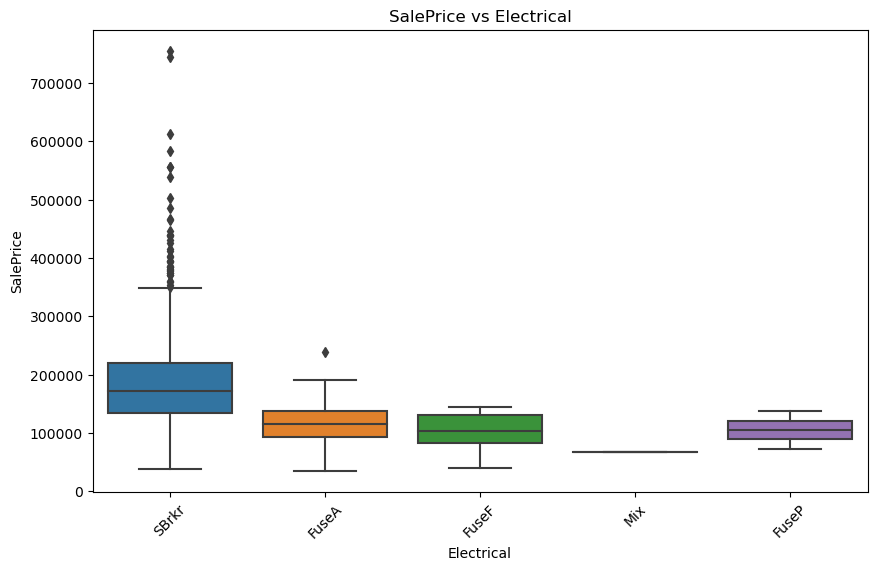

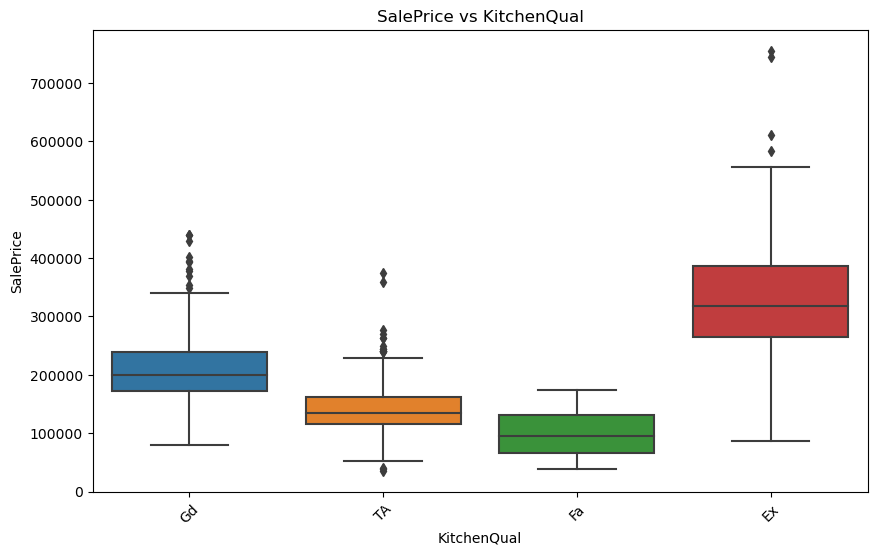

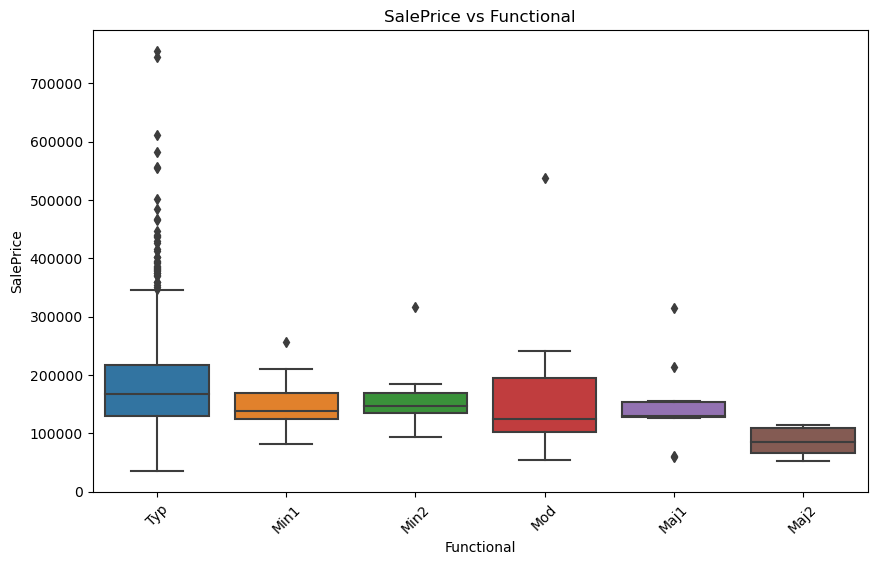

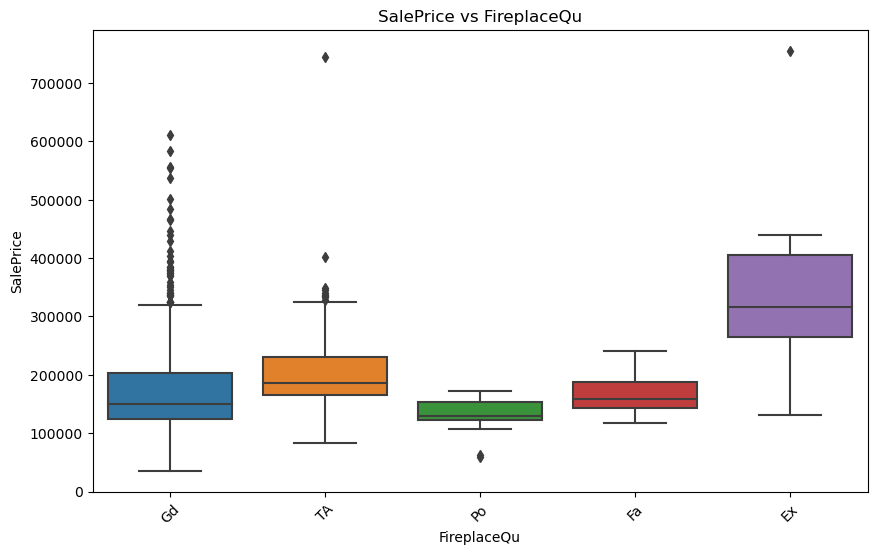

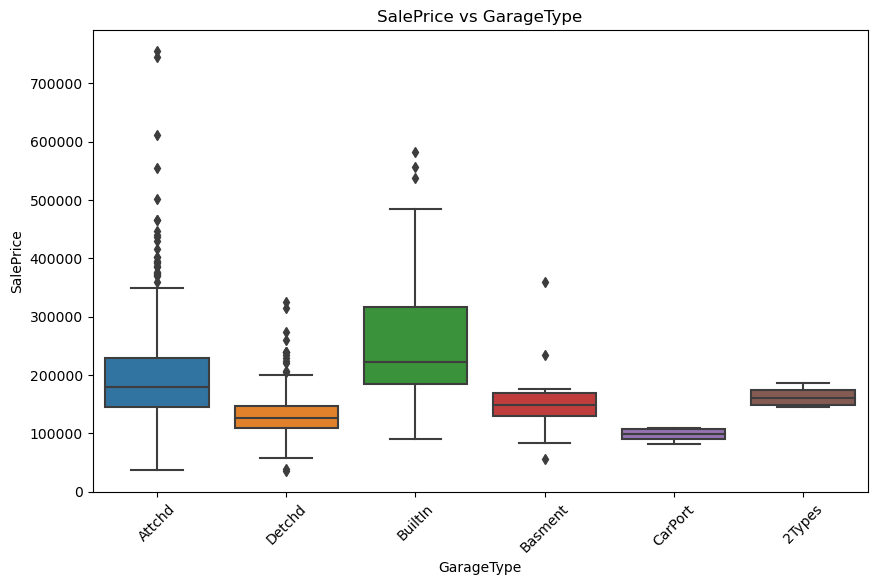

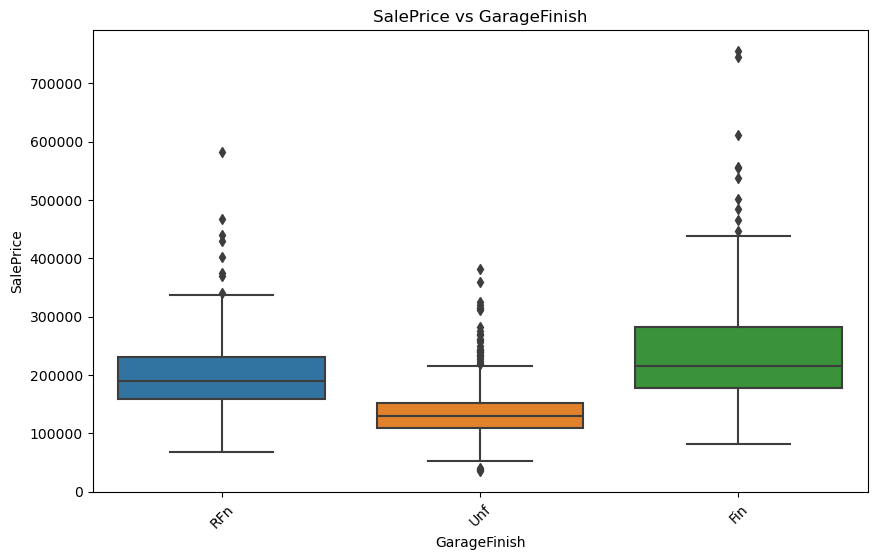

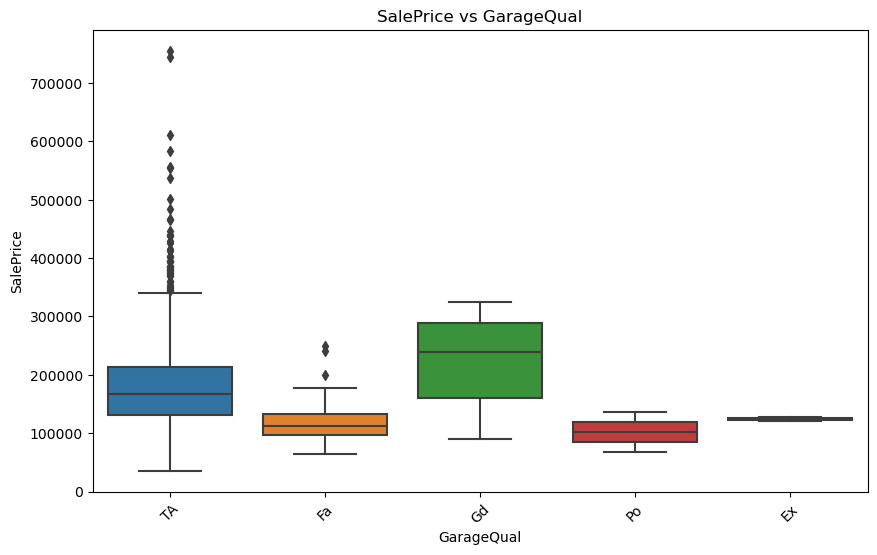

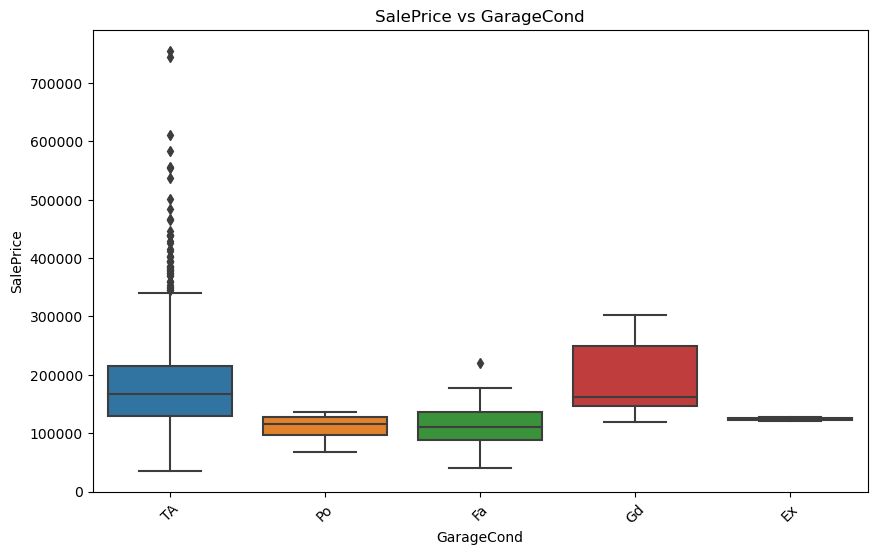

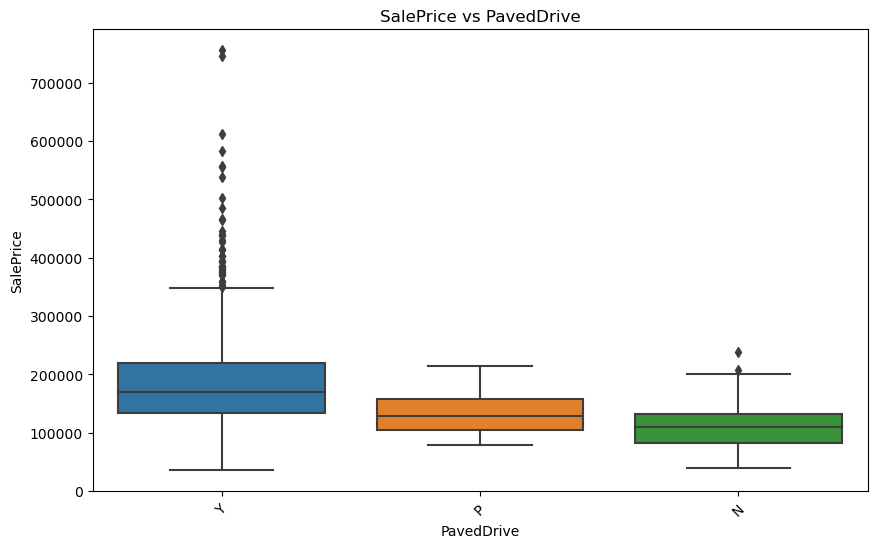

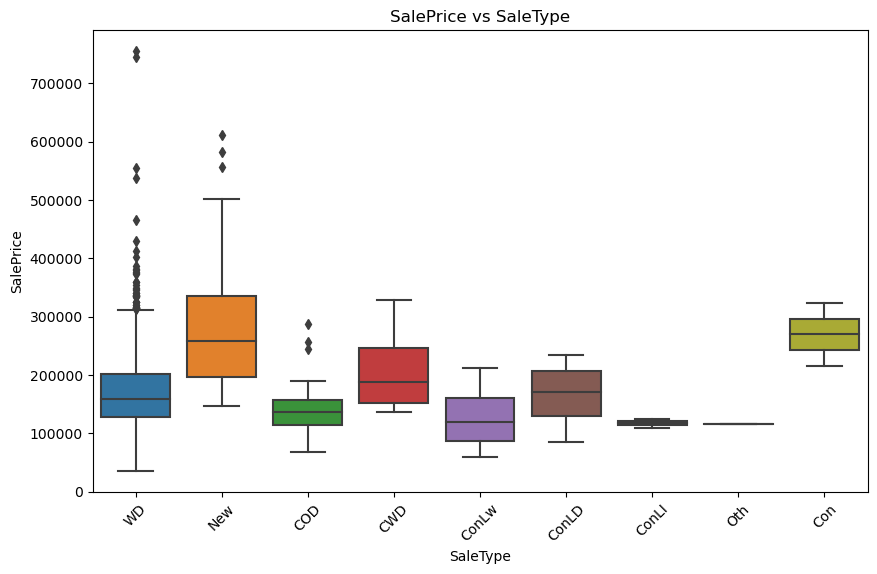

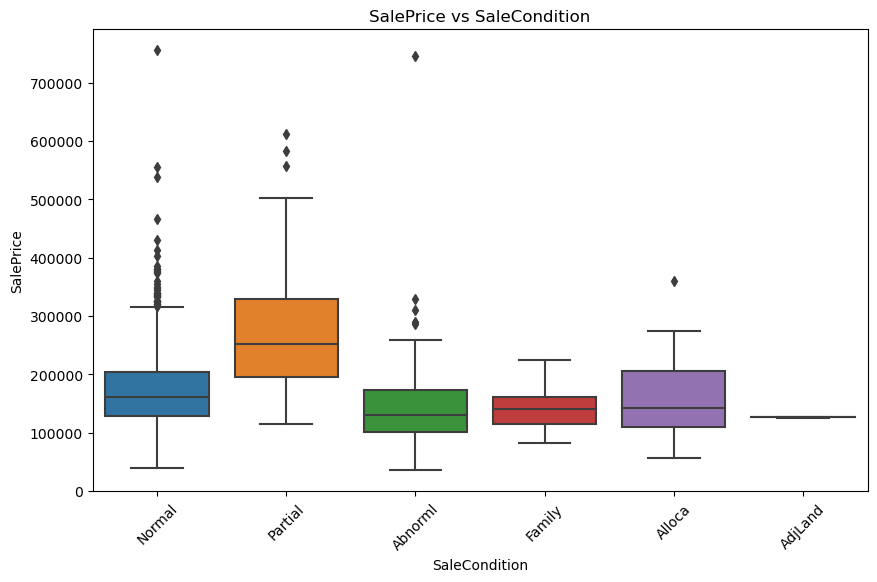

In [108]:
# Selecting non-numeric features
categorical_features = train_data.select_dtypes(include=['object']).columns

# Creating boxplots for each categorical feature
for col in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=col, y='SalePrice', data=train_data)
    plt.title(f'SalePrice vs {col}')
    plt.xticks(rotation=45)
    plt.show()


Drop features do not show a substantial difference in the distribution and features have very few observations in one or more categories.

In [109]:
features_to_drop = [
     'Street' ,'Utilities','LotConfig','Condition2','BldgType','HouseStyle','RoofMatl',
    'Exterior1st','Exterior2nd','ExterCond','BsmtCond','Heating','HeatingQC','CentralAir',
    'Electrical','Functional','GarageCond','GarageFinish','PavedDrive','BsmtFinType2'
]
train_data.drop(features_to_drop, axis=1, inplace=True)

Combining 'LotArea' and 'LotShape' into a single feature

In [110]:
# Create a mapping for LotShape values to ordinal numbers
lot_shape_mapping = {
    'Reg': 1,
    'IR1': 2,
    'IR2': 3,
    'IR3': 4
}

# Apply the mapping to your DataFrame
train_data['LotShape_Ordinal'] = train_data['LotShape'].map(lot_shape_mapping)

# Create the interaction term
train_data['LotArea_Shape_Interaction'] = train_data['LotArea'] * train_data['LotShape_Ordinal']

# Drop the original 'LotArea' and 'LotShape' columns
train_data.drop(['LotArea', 'LotShape'], axis=1, inplace=True)

In [111]:
#Drop '1stFlrSF ’，‘2ndFlrSF’
train_data.drop(['1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)

Combining 'BsmtFinSF1' and 'BsmtUnfSF' into 'TotalBsmtSF'

In [112]:
train_data['TotalBsmtSF'] = train_data['BsmtFinSF1'] + train_data['BsmtUnfSF']
train_data.drop(['BsmtFinSF1', 'BsmtUnfSF'], axis=1, inplace=True)

Combining 'FullBath', 'HalfBath', 'BsmtFullBath' into 'TotalBaths' and consider the different weights for the types of bathrooms

In [113]:
# Calculate the total number of bathrooms
train_data['TotalBaths'] = train_data['BsmtFullBath'] + train_data['FullBath'] + (train_data['HalfBath'] * 0.5)

train_data.drop(['BsmtFullBath', 'FullBath', 'HalfBath'], axis=1, inplace=True)

Drop '3SsnPorch', 'MoSold' and 'ScreenPorch' because their correlation with 'SalePrice' equal or less than 0.1

In [114]:
train_data.drop(['3SsnPorch', 'MoSold', 'ScreenPorch'], axis=1, inplace=True)

In [115]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   MSZoning                   1022 non-null   object 
 1   LandContour                1022 non-null   object 
 2   LandSlope                  1022 non-null   object 
 3   Neighborhood               1022 non-null   object 
 4   Condition1                 1022 non-null   object 
 5   OverallQual                1022 non-null   int64  
 6   YearBuilt                  1022 non-null   int64  
 7   YearRemodAdd               1022 non-null   int64  
 8   RoofStyle                  1022 non-null   object 
 9   MasVnrType                 1022 non-null   object 
 10  MasVnrArea                 1022 non-null   float64
 11  ExterQual                  1022 non-null   object 
 12  Foundation                 1022 non-null   object 
 13  BsmtQual                   1022 non-null   objec

Deal with nonnumeric features

Binary Encoding

In [116]:
# Binary encode the 'RoofStyle' column where '1' represents 'Gable' or 'Hip' roofs and '0' all others
train_data['RoofStyle_Binary'] = train_data['RoofStyle'].apply(lambda x: 1 if x in ['Gable', 'Hip'] else 0)

# Optionally, drop the original 'RoofStyle' column if you no longer need it
train_data.drop('RoofStyle', axis=1, inplace=True)

In [117]:
train_data['MasVnrType_BrkFace'] = train_data['MasVnrType'].apply(lambda x: 1 if x == 'BrkFace' else 0)

train_data.drop('MasVnrType', axis=1, inplace=True)

Ordinal Encoding

In [118]:
# Define a mapping from quality ratings to numbers
quality_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}

# Apply ordinal encoding
for feature in ['ExterQual', 'BsmtQual', 'FireplaceQu', 'GarageQual','KitchenQual']:
    train_data[feature] = train_data[feature].map(quality_mapping)

In [119]:
land_contour_mapping = {'Lvl': 4, 'Bnk': 3, 'HLS': 2, 'Low': 1}
train_data['LandContour'] = train_data['LandContour'].map(land_contour_mapping)

In [120]:
land_slope_mapping = {'Gtl': 3, 'Mod': 2, 'Sev': 1}
train_data['LandSlope'] = train_data['LandSlope'].map(land_slope_mapping)

In [121]:
ordinal_mapping = {
    'No': 0,   # No Basement
    'Unf': 1,  # Unfinished
    'LwQ': 2,  # Low Quality
    'Rec': 3,  # Average Quality
    'BLQ': 4,  # Below Average Quality
    'ALQ': 5,  # Average Living Quarters
    'GLQ': 6   # Good Living Quarters
}

# Apply the mapping to the 'BsmtFinType1' column
train_data['BsmtFinType1'] = train_data['BsmtFinType1'].map(ordinal_mapping)

Label Encoding

In [122]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the 'MSZoning' feature
train_data['MSZoning'] = label_encoder.fit_transform(train_data['MSZoning'])

Target Encoding

In [123]:
# Calculate the mean SalePrice for each neighborhood
neighborhood_target_mean = train_data.groupby('Neighborhood')['SalePrice'].mean()

# Map the mean SalePrice to each neighborhood in the dataset
train_data['Neighborhood'] = train_data['Neighborhood'].map(neighborhood_target_mean)

In [124]:
# Define a mapping from current conditions to broader categories
condition_mapping = {
    'Norm': 'Normal',
    'Feedr': 'NearFeederRoad',
    'Artery': 'NearArteryRoad',
    'RRAn': 'NearRailroad',
    'RRNn': 'NearRailroad',
    'RRNe': 'NearRailroad',
    'RRAe': 'NearRailroad',
    'PosN': 'PositiveFeature',
    'PosA': 'PositiveFeature'
}

# Apply the mapping to the 'Condition1' column
train_data['Condition1'] = train_data['Condition1'].map(condition_mapping)
# Calculate the mean SalePrice for each condition
condition_target_mean = train_data.groupby('Condition1')['SalePrice'].mean()

# Map the mean SalePrice to each condition in the dataset
train_data['Condition1'] = train_data['Condition1'].map(condition_target_mean)

In [125]:
foundation_target_mean = train_data.groupby('Foundation')['SalePrice'].mean().to_dict()

train_data['Foundation'] = train_data['Foundation'].map(foundation_target_mean)

In [126]:
mean_sale_price = train_data.groupby('BsmtExposure')['SalePrice'].mean().to_dict()

train_data['BsmtExposure'] = train_data['BsmtExposure'].map(mean_sale_price)

In [127]:
mean_GarageType = train_data.groupby('GarageType')['SalePrice'].mean().to_dict()

train_data['GarageType'] = train_data['GarageType'].map(mean_GarageType)

In [128]:
mean_SaleType = train_data.groupby('SaleType')['SalePrice'].mean().to_dict()

train_data['SaleType'] = train_data['SaleType'].map(mean_SaleType)

In [129]:
SaleCondition_mean = train_data.groupby('SaleCondition')['SalePrice'].mean().to_dict()

train_data['SaleCondition'] = train_data['SaleCondition'].map(SaleCondition_mean)

Standardization

In [130]:
numerical_features = train_data.select_dtypes(include=['int64', 'float64'])

scaler = StandardScaler()

train_data[numerical_features.columns] = scaler.fit_transform(numerical_features)

In [133]:
train_data.to_csv('final_train_data.csv', index=False)